# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

39748


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\Cis_chromosome'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')


Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Cis_chromosome\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Cis_chromosome\figures.


## 1.2 setting up plotting parameters

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rc('font', family='serif')
plt.rc('font', serif='Arial')


# Other required plotting parameters
_dpi = 300
_font_size = 7.5
_page_width = 5.5
import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})  

In [6]:
# cell labels from RNA-MERFISH and celltype prediction
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]
# cell palette from RNA-MERFISH UMAP and stats
celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}


In [7]:
# this is the plotting order noted based on the snRNA transcriptional acitivty;
# we'd use this for all the graphs in this notebook
# use the snRNA data below (# section 3.1.1) if needs to re-calculate
sorted_cellplot_order = ['Micro', 'Oligo', 'Endo', 'OPC', 'Astro', 'Vip', 'Lamp5',
                  'L5/6 NP', 'Sst', 'Sncg', 'Pvalb', 'L4/5 IT', 'L6 CT',
                  'L6 IT', 'L6b', 'L2/3 IT', 'L5 IT', 'L5 ET']

# 2. Load codebook and chromosome size

## Codebook

**Codebook** example from [codebook_link](../0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [8]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin\resources'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


## Chromosome size by radius gyration

Data below can be generated using notebook as 

[2_nuclear_chrom_size/5_calculate_chromatin_Rg](../2_nuclear_chrom_size/5_calculate_chromatin_Rg.ipynb)

In [9]:
chrom_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0312\chromatin_property'
chromosome_size_df = pd.read_csv(os.path.join(chrom_folder, 'WT_MOp_Rg.csv'), index_col=0)

chromosome_size_df.head()

,rg,uid,majorType,subclass,chr,fiberidx
0,1.241714,100002611273212566104762860093574587628,Gluta,L4/5 IT,chr1,1
1,1.163226,100002611273212566104762860093574587628,Gluta,L4/5 IT,chr10,1
2,1.888276,100002611273212566104762860093574587628,Gluta,L4/5 IT,chr11,1
3,1.759560,100002611273212566104762860093574587628,Gluta,L4/5 IT,chr12,1
4,1.404082,100002611273212566104762860093574587628,Gluta,L4/5 IT,chr13,1


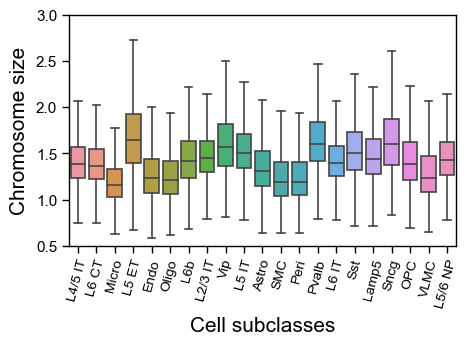

In [10]:
%matplotlib inline

import seaborn as sns
import scanpy as sc

# plot
fig, ax = plt.subplots(figsize=(5,3),dpi=100)

sns.boxplot(data=chromosome_size_df, x='subclass', y='rg', 
            #order = sub_sorted_cellplot_order, 
            ax=ax, 
            fliersize=0,
            #palette=celltype_palette,
           )

#ax.set_xticklabels(sorted_types, rotation=70, fontsize=12)
plt.tick_params(axis='y', labelsize=11) 
plt.tick_params(axis='x', rotation=75, labelsize=10) 

ax.set_xlabel("Cell subclasses", fontsize=15, labelpad=5)
ax.set_ylabel("Chromosome size", fontsize=15, labelpad=5)


ax.set_ylim([0.5,3])
ax.grid(False)

# 3. Chromosome size and median distances

## load median map


Data below can be generated from the notebook as:

[preprocess/2_dna_merfish/scripts/2_spot_pick/4_summarize_jie_to_dict](../../preprocess/2_dna_merfish/scripts/2_spot_pick/4_summarize_jie_to_dict.ipynb)

In [11]:
# load main folder
postanalysis_folder = r'\\10.245.74.158\Chromatin_NAS_8\Exported_data\jie_CW_decode\postanalysis_v2CW_sorted'

# subclass to median distance dict
class_2_median_filename = os.path.join(postanalysis_folder, 'subclass_2_medianDict.pkl')
if os.path.exists(class_2_median_filename):
    print("Loading median")
    class_2_medianDict = pickle.load(open(class_2_median_filename, 'rb'))

Loading median


## load median summary

Data summary below can be generated by the notebook

[1_cis_distance_summary_across_celltypes](1_cis_distance_summary_across_celltypes.ipynb)

In [12]:
import tqdm

distmap_summary_df_list = []
for _class in tqdm.tqdm(class_2_medianDict.keys()):
    _class_distmap_summary_df = pd.read_csv(os.path.join(output_analysis_folder,'Cis_dismap_summary',
                                                  f'raw_cis_distmap_subclass_{_class.replace("/","_").replace(" ","_")}_summary.csv'),
                                           index_col=0)
    distmap_summary_df_list.append(_class_distmap_summary_df)
    
distmap_summary_df = pd.concat(distmap_summary_df_list)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  5.60it/s]


In [18]:
distmap_summary_df.head()

,loc_1,loc_2,pairwise_distance,subclass,chr,genomic_distance
loci_pairs,,,,,,
0,chr1_3742742_3759944,chr1_3742742_3759944,0.000000,Oligo,1,0
1,chr1_3742742_3759944,chr1_6245958_6258969,0.922651,Oligo,1,2503216
2,chr1_3742742_3759944,chr1_8740008_8759916,1.070654,Oligo,1,4997266
3,chr1_3742742_3759944,chr1_9627926_9637875,1.060591,Oligo,1,5885184
4,chr1_3742742_3759944,chr1_9799472_9811359,1.093519,Oligo,1,6056730


## plot

In [13]:
chrom_list = [c for c in np.unique(codebook_df['chr']) if c!= 'Y']
chrom_list = [c for c in chrom_list  if c!='X']
chrom_list.sort(key = int)
chrom_list.append('X')

In [14]:
sorted_cellplot_idx_order = np.argsort(chromosome_size_df.groupby(by='subclass')['rg'].median())
sorted_cellplot_order = chromosome_size_df.groupby(by='subclass')['rg'].median().index[sorted_cellplot_idx_order]
sorted_cellplot_order

Index(['Micro', 'SMC', 'Peri', 'Oligo', 'Endo', 'VLMC', 'Astro', 'L6 CT',
       'L4/5 IT', 'OPC', 'L6 IT', 'L6b', 'L5/6 NP', 'Lamp5', 'L2/3 IT', 'Sst',
       'L5 IT', 'Vip', 'Sncg', 'Pvalb', 'L5 ET'],
      dtype='object', name='subclass')

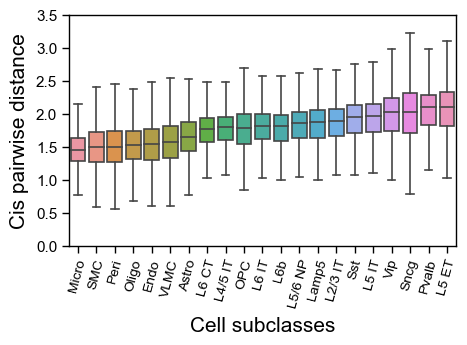

In [15]:
%matplotlib inline

import seaborn as sns
import scanpy as sc

# plot
fig, ax = plt.subplots(figsize=(5,3),dpi=100)

sns.boxplot(data=distmap_summary_df, x='subclass', y='pairwise_distance', 
            order = sorted_cellplot_order, 
            ax=ax, 
            fliersize=0,
            #palette=celltype_palette,
           )

#ax.set_xticklabels(sorted_types, rotation=70, fontsize=12)
plt.tick_params(axis='y', labelsize=11) 
plt.tick_params(axis='x', rotation=75, labelsize=10) 

ax.set_xlabel("Cell subclasses", fontsize=15, labelpad=5)
ax.set_ylabel("Cis pairwise distance", fontsize=15, labelpad=5)


ax.set_ylim([0,3.5])
ax.grid(False)

#plt.savefig(os.path.join(output_figure_folder, f'Trans_chrom_pairwise_distance_summary.pdf'), 
            #transparent=True, dpi=300, bbox_inches='tight')

plt.show()


## plot with all genomic distances included

In [16]:
sorted_cellplot_order

Index(['Micro', 'SMC', 'Peri', 'Oligo', 'Endo', 'VLMC', 'Astro', 'L6 CT',
       'L4/5 IT', 'OPC', 'L6 IT', 'L6b', 'L5/6 NP', 'Lamp5', 'L2/3 IT', 'Sst',
       'L5 IT', 'Vip', 'Sncg', 'Pvalb', 'L5 ET'],
      dtype='object', name='subclass')

meta NOT subset; don't know how to subset; dropped


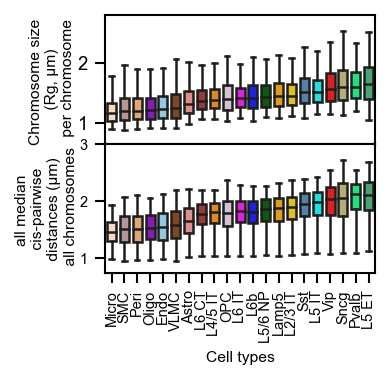

In [24]:
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['figure.dpi'] = 300

#plt.style.use('dark_background')

# gd for all, long, median, short distances
#sel_sorted_bin_keys = [(0., np.inf),(100000000, np.inf),(10000000, np.inf),(0, 2000000)]
#ylabel_list = ['chrom \n size', 'all \n distances','>50Mb','>10Mb','<2Mb']
#ylim_list = [[0.2,3],[0.3,3.5],[0.3,3.5],[0.3,3.5],[0,1.55],]


sel_sorted_bin_keys = [(0., np.inf),(10000000, np.inf),(0, 2000000)][:1]
ylabel_list = ['Chromosome size \n (Rg, \u03bcm) \n per chromosome', 
               'all median \n cis-pairwise \n distances (\u03bcm) \n all chromosomes','>10Mb','<2Mb'][:2]
ylim_list = [[0.65,2.8],[0.75,3],[0.3,3.5],[0,1.55],][:2]

fig, axes = plt.subplots(len(sel_sorted_bin_keys)+1,1, 
                         figsize=(_page_width/2.75,_page_width/2.75*1), 
                         sharex=True, sharey=False, dpi=150)

# plot chromosome size
sns.boxplot(data=chromosome_size_df, x='subclass', y='rg', 
            order = sorted_cellplot_order, 
            ax=axes[0], 
            fliersize=0,
            palette=celltype_palette,
            whis=[5, 95],
            width=0.7,
           )

# plot cis distance by 
for _idx,_bin_key in enumerate(sel_sorted_bin_keys):
    _ax_idx = _idx+1
    
    short_gd_th = _bin_key[0]
    long_gd_th = _bin_key[1]

    sel_distmap_summary_df = distmap_summary_df[(distmap_summary_df['genomic_distance']<=long_gd_th)&
                                            (distmap_summary_df['genomic_distance']>short_gd_th)]
    
    sns.boxplot(data=sel_distmap_summary_df, x='subclass', y='pairwise_distance', 
            order = sorted_cellplot_order, 
            ax=axes[_ax_idx], 
            fliersize=0,
                whis=[5, 95],
            palette=celltype_palette,
                width=0.7,
           )

for _ax_idx, _ax in enumerate(axes):
    _ax.set_ylabel(ylabel_list[_ax_idx], rotation=90, fontsize=_font_size,labelpad=1)
    plt.tick_params(axis='y', labelsize=_font_size-0.5) 
    if _ax_idx!=len(axes)-1:
        _ax.tick_params(labelbottom=False)
        _ax.set_xlabel("", rotation=0, fontsize=_font_size)
        _ax.tick_params(axis='x', rotation=90, labelsize=_font_size-0.5,length=0) 
    else:
        _ax.set_xlabel("Cell types", rotation=0, fontsize=_font_size)
        _ax.tick_params(axis='x', rotation=90, labelsize=_font_size-0.5) 
    if len(ylim_list[_ax_idx])==2:
        _ax.set_ylim(ylim_list[_ax_idx])
    _ax.grid(False)

fig.subplots_adjust(wspace=0.0, hspace=0.0, left=0.05, right=0.95, top=0.98, bottom=0.12)
plt.savefig(os.path.join(output_figure_folder, f'Cis_chrom_pairwise_distance_and_chr_size_summary.pdf'), 
            transparent=True, dpi=300, bbox_inches='tight')

plt.show()

# 4. Contact by genomic distance


Data below can be generated from the notebook as:

[preprocess/2_dna_merfish/scripts/2_spot_pick/5_summarize_jie_to_dict_contact750](../../preprocess/2_dna_merfish/scripts/2_spot_pick/5_summarize_jie_to_dict_contact750.ipynb)

In [41]:
# load main folder
postanalysis_folder = r'\\10.245.74.158\Chromatin_NAS_8\Exported_data\jie_CW_decode\postanalysis_v2CW_sorted'
postanalysis_folder_CW = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0312'

class_2_contact_filename = os.path.join(postanalysis_folder_CW, 'subclass_2_contactDict_750.pkl')
print(class_2_contact_filename)
if os.path.exists(class_2_contact_filename):
    print("Loading contact")
    class_2_contactDict = np.load(class_2_contact_filename, allow_pickle=True)

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0312\subclass_2_contactDict_750.pkl
Loading contact


# 5. Contact frequency from single cell (aka ratio over total number of contacts in singel cell )

## load singlecell contact frequncy summary

Data can be generated by notebook as

[2_cis_contact_by_genomic_dsitance_from_singlecell_zxy](2_cis_contact_by_genomic_dsitance_from_singlecell_zxy.ipynb)

In [44]:
import pickle
contact_summary_dict = pickle.load(open(os.path.join(output_analysis_folder,'cis_contact_singlecell_frequency_subclass.pkl'),'rb'))

## summarize to plot dataframe

In [45]:
import tqdm
gene_dist_bins = [(0,2000000), 
                  (2000000,5000000), 
                  (5000000, 10000000),
                  (10000000,20000000),
                  (20000000,50000000),
                  (50000000,200000000)]

res_dict = {k:{} for k in gene_dist_bins}


contact_num_th = 1000

for _class, _summary_list in tqdm.tqdm(contact_summary_dict.items()):
    
    for _k, _v in res_dict.items():
        _v[_class] = []

for _class, _summary_list in tqdm.tqdm(contact_summary_dict.items()):
    for _bin_query in res_dict.keys():
        for _contact_summary in _summary_list:
            contact_query = 0
            contact_total = 0
            for _chr, _contact_bybin in _contact_summary.items():
                contact_query += _contact_bybin[_bin_query]
                contact_total += _contact_bybin['total']
                
            contact_query_ratio = contact_query/contact_total
            # set a th for clean cell
            if contact_total >= contact_num_th:
                res_dict[_bin_query][_class].append(contact_query_ratio)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 10.76it/s]


In [46]:
# summarize to dataframe
_contact_result_df_list = []
_contact_result_df_dict = {}
for _bin_query, _contact_result in res_dict.items():
    _contact_result_df = pd.DataFrame.from_dict(res_dict[_bin_query], orient='index').transpose()
    _contact_result_df_list.append(_contact_result_df)
    _contact_result_df_dict[_bin_query] = _contact_result_df
    
    
sel_sorted_bin_keys = [(20000000,50000000),(10000000, 20000000),(2000000,5000000), (0, 2000000)]
# cell labels as above
sorted_cell_labels = ['Micro', 'SMC', 'Peri', 'Oligo', 'Endo', 'VLMC', 'Astro', 'L6 CT',
       'L4/5 IT', 'OPC', 'L6 IT', 'L6b', 'L5/6 NP', 'Lamp5', 'L2/3 IT', 'Sst',
       'L5 IT', 'Vip', 'Sncg', 'Pvalb', 'L5 ET']


res_dict_df_list= []
for _bin_key in sel_sorted_bin_keys:
    res_dict_df_list.append(_contact_result_df_dict[_bin_key])

res_dict_df=pd.concat(res_dict_df_list)
cell_type_medians = np.nanmedian(res_dict_df, axis=0)
#sorted_cell_labesl = res_dict_df.columns[np.argsort(cell_type_medians)]
res_dict_df = res_dict_df[sorted_cell_labels[::-1]]
res_dict_df = res_dict_df*100

## plot

meta NOT subset; don't know how to subset; dropped


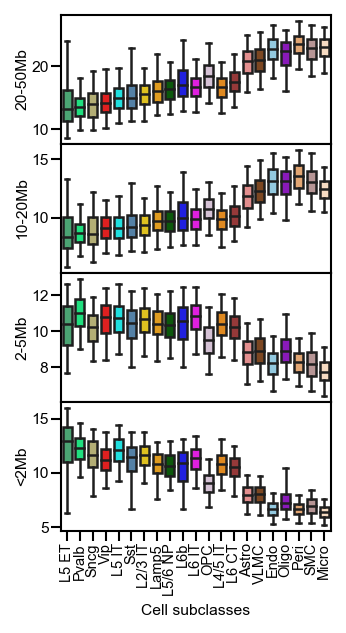

In [48]:
%matplotlib inline

fig, axes = plt.subplots(len(sel_sorted_bin_keys),1, 
                         figsize=(_page_width/2.75,_page_width/2.75*2), 
                         sharex=True, sharey=False, dpi=150)



ylabel_list = ['20-50Mb', '10-20Mb','2-5Mb','<2Mb']
#ylim_list = [[0.2,3],[0.3,3.5],[0.3,3.5],[0,1.55],]
ylim_list = [[],[],[],[],]
#cell_type_medians = np.nanmedian(res_dict_df, axis=0)
#sorted_cell_labels = res_dict_df.columns[np.argsort(cell_type_medians)]


for _idx,_bin_key in enumerate(sel_sorted_bin_keys):
    res_dict_df = _contact_result_df_dict[_bin_key]
    cell_type_medians = np.nanmedian(res_dict_df, axis=0)
    
    # get label order from the first bin
    #if _idx == 0:
        #sorted_cell_labesl = res_dict_df.columns[np.argsort(cell_type_medians)]
        
    res_dict_df = res_dict_df[sorted_cell_labels[::-1]]
    res_dict_df = res_dict_df*100
    sns.boxplot(res_dict_df, showfliers=False, 
                whis=[5, 95],
                ax=axes[_idx],palette=celltype_palette,width=0.7)
    axes[_idx].tick_params(labelleft=False)

        
for _ax_idx, _ax in enumerate(axes):
    _ax.set_ylabel(ylabel_list[_ax_idx], rotation=90, fontsize=_font_size,labelpad=1)
    _ax.tick_params(axis='y', labelsize=_font_size,pad=1,labelleft=True)
    if _ax_idx!=len(axes)-1:
        _ax.tick_params(labelbottom=False)
        _ax.set_xlabel("", rotation=0, fontsize=_font_size-0.5)
        _ax.tick_params(axis='x', rotation=90, pad=1,labelsize=0,length=0) 
    else:
        _ax.set_xlabel("Cell subclasses", rotation=0, fontsize=_font_size)
        _ax.tick_params(axis='x', rotation=90, pad=1,labelsize=_font_size-0.5) 
    if len(ylim_list[_ax_idx])==2:
        _ax.set_ylim(ylim_list[_ax_idx])
    _ax.grid(False)

fig.subplots_adjust(wspace=0.0, hspace=0.0, left=0.05, right=0.95, top=0.98, bottom=0.12)
plt.savefig(os.path.join(output_figure_folder, f'Cis_chrom_pairwise_contact_frequency_singlecell.pdf'), 
            transparent=True, dpi=300, bbox_inches='tight')

plt.show()